<html>
    <div style="background-color: lightskyblue; padding: 30px; color: black; text-align: center;">
    <h1>CAB420 - Assignment 2</h1>
    <h2>Building a DCNN Model to Classify Animals and Endangered Status</h2>
    </div>
</html>

Loading in the main modules for the project

In [1]:
import numpy as np
import pandas as pd
import os
import scipy
import matplotlib.pyplot as plt
import glob
import cv2
from PIL import Image

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import seaborn as sns
import random

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

2025-05-25 16:19:56.362147: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Utility Functions

In [2]:
def load_images_from_folders(root_dir):
    # Root directory is 256_ObjectCategories
    
    seen_paths = []
    unseen_paths = []
    # This is the main animals directory
    directories = os.listdir(root_dir)
    directories.sort()

    # This will have the animal directories
    for dirpath in directories:
        if dirpath != '.DS_Store':
            os.chdir(os.path.join(root_dir, dirpath))
            
            seen_unseen_dir = os.listdir(os.getcwd())
            seen_unseen_dir.sort()      
            seen_unseen_dir.pop(0)

            seen_image_count = 0
            unseen_image_count = 0
            # This is the seen and unseen directories
            for folder in seen_unseen_dir:
                # Go into the seen/unseen directory
                os.chdir(os.path.join(root_dir, dirpath, folder))

                # Grab the images in the seen/unseen directory
                images_in_dir = os.listdir(os.getcwd())
                images_in_dir.sort()

                # Append each of the images to the image_paths list
                for image in images_in_dir:
                    if folder == 'seen_images':
                        seen_paths.append(os.path.join(root_dir, dirpath, folder, image))
                        seen_image_count += 1
                        
                    elif folder == 'unseen_images':
                        unseen_paths.append(os.path.join(root_dir, dirpath, folder, image))
                        unseen_image_count += 1
                    else:
                        print(f"Unknown folder: {folder}")
                        continue

                    # Get out of the seen/unseen directory onto the animals directory
                    os.chdir('..')
                os.chdir('..')
            
            os.chdir('..')
    return seen_paths, unseen_paths

def read_images(image_paths):
    images = []
    for path in image_paths:
        try:
            img = np.array(Image.open(path)) # or img = cv2.imread(path)
            images.append(img)
        except Exception as e:
             print(f"Error loading image: {path} - {e}")    
    return images

# def eval_model(model, train, train_y, test, test_y):
#     fig = plt.figure(figsize=[20, 8])    

#     ax = fig.add_subplot(1, 2, 1)    
#     # predict on the training set
#     pred = model.predict(train, verbose=False);
#     # get indexes for the predictions and ground truth, this is converting back from a one-hot representation
#     # to a single index
#     indexes = tf.argmax(pred, axis=1)
#     gt_idx = tf.argmax(train_y, axis=1)

#     # plot the confusion matrix, I'm using tensorflow and seaborn here, but you could use
#     # sklearn as well
#     confusion_mtx = tf.math.confusion_matrix(gt_idx, indexes) 
#     sns.heatmap(confusion_mtx, xticklabels=range(10), yticklabels=range(10), 
#             annot=True, fmt='g', ax=ax)
#     # set the title to the F1 scope
#     ax.set_title('Training, F1 Score: %f' % f1_score(gt_idx, indexes, average='weighted'))

#     # repeat visualisation for the test set
#     ax = fig.add_subplot(1, 2, 2)  
#     pred = model.predict(test, verbose=False);
#     indexes = tf.argmax(pred, axis=1)
#     gt_idx = tf.argmax(test_y, axis=1)

#     confusion_mtx = tf.math.confusion_matrix(gt_idx, indexes) 
#     sns.heatmap(confusion_mtx, xticklabels=range(10), yticklabels=range(10), 
#             annot=True, fmt='g', ax=ax)
#     ax.set_title('Testing, F1 Score: %f' % f1_score(gt_idx, indexes, average='weighted'))

def eval_model(model, history, x_test, y_test):
    test_scores = model.evaluate(x_test, y_test, verbose=0)
    print('Test loss:', test_scores[0])
    print('Test accuracy:', test_scores[1])

    pred = model.predict(x_test, verbose=False);
    indexes = keras.ops.argmax(pred, axis=1)
    
    cm = confusion_matrix(y_test, indexes)
    fig = plt.figure(figsize=[8, 8])
    ax = fig.add_subplot(1, 1, 1)
    c = ConfusionMatrixDisplay(cm, display_labels=range(10))
    c.plot(ax = ax)
    
    print(classification_report(y_test, indexes))

    fig = plt.figure(figsize=[8, 4])
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(history['loss'], label='Training Loss')
    ax.plot(history['accuracy'], label='Training Accuracy')
    ax.plot(history['val_loss'], label='Validation Loss')
    ax.plot(history['val_accuracy'], label='Validation Accuracy')
    ax.set_xlabel('Training Epochs')
    ax.set_ylabel('Accuracy or Loss')
    ax.legend()

def get_triplet_data(imgs, labels, batch_size):

    image_a = np.zeros((batch_size, np.shape(imgs)[1], np.shape(imgs)[2], np.shape(imgs)[3]));
    image_b = np.zeros((batch_size, np.shape(imgs)[1], np.shape(imgs)[2], np.shape(imgs)[3]));
    image_c = np.zeros((batch_size, np.shape(imgs)[1], np.shape(imgs)[2], np.shape(imgs)[3]));
    
    for i in range(batch_size):
        
        idx1 = random.randint(0, len(imgs) - 1)
        idx2 = random.randint(0, len(imgs) - 1)
        idx3 = random.randint(0, len(imgs) - 1)

        while (labels[idx1] != labels[idx2]):
            idx2 = random.randint(0, len(imgs) - 1)            
                
        while (labels[idx1] == labels[idx3]):
            idx3 = random.randint(0, len(imgs) - 1)

        image_a[i, :, :, :] = imgs[idx1,:,:,:]
        image_b[i, :, :, :] = imgs[idx2,:,:,:]
        image_c[i, :, :, :] = imgs[idx3,:,:,:]

    return [image_a, image_b, image_c]

def plot_triplets(x):
    fig = plt.figure(figsize=[25, 10])
    for i in range(9):
        ax = fig.add_subplot(3, 9, i*3 + 1)
        ax.imshow(x[0][i,:], cmap=plt.get_cmap('Greys'))
        ax.set_title('Triple ' + str(i) + ': Anchor')

        ax = fig.add_subplot(3, 9, i*3 + 2)
        ax.imshow(x[1][i,:], cmap=plt.get_cmap('Greys'))    
        ax.set_title('Triple ' + str(i) + ': Positive')

        ax = fig.add_subplot(3, 9, i*3 + 3)
        ax.imshow(x[2][i,:], cmap=plt.get_cmap('Greys'))    
        ax.set_title('Triple ' + str(i) + ': Negative')

def generate_pseudo_labels(seen_data, unseen_X_data, model, threshold = None):
    seen_train_X = seen_data['seen_train_X']
    species_labelled_train_Y = seen_data['species_labelled_train_Y']
    endangered_labelled_train_Y = seen_data['endangered_labelled_train_Y']

    if threshold is None:
        print('No threshold provided, need to specify a threshold for labelling')
        
    species_pseudo_labels = []
    endangered_pseudo_labels = []
    pseudo_images = []

    for i in range(len(unseen_X_data)):
        species_prediction, endangered_prediction = model.predict(unseen_X_data[i:i+1])
        
        species_task = tf.reduce_max(species_prediction, axis=1)
        endangered_task = tf.reduce_max(endangered_prediction, axis=1)

        mask = tf.logical_and(species_task >= threshold, endangered_task >= threshold)
        print(mask)
        
        selected_image = tf.boolean_mask(unseen_X_data[i:i+1], mask)

        selected_species = tf.boolean_mask(species_prediction, mask)
        selected_endangered = tf.boolean_mask(endangered_prediction, mask)

        pseudo_images.append(selected_image)
        species_pseudo_labels.append(selected_species)
        endangered_pseudo_labels.append(selected_endangered)

    pseudo_images = tf.concat(pseudo_images, axis=0)
    species_pseudo_labels = tf.concat(species_pseudo_labels, axis=0)
    endangered_pseudo_labels = tf.concat(endangered_pseudo_labels, axis=0)

    combine_images = tf.concat([seen_train_X, pseudo_images], axis=0)
    combine_species_labels = tf.concat([species_labelled_train_Y, species_pseudo_labels], axis=0)
    combine_endangered_labels = tf.concat([endangered_labelled_train_Y, endangered_pseudo_labels], axis=0)

    combine_dataset = tf.data.Dataset.from_tensor_slices(
        (combine_images, {'species_pred' : combine_species_labels, 'endangered_pred': combine_endangered_labels})
    )
    combine_dataset = combine_dataset.shuffle(1024).batch(32)

    print(f'Number of species pseudo labels: {len(combine_species_labels)}\nNumber of endangered pseudo labels: {len(combine_endangered_labels)}') 

    return combine_dataset, species_pseudo_labels, endangered_pseudo_labels, pseudo_images

In [3]:
image_root = '/Users/aidanlockwood/Documents/GitHub/CAB420-Codebase/Assessment/assignment_2/data/256_ObjectCategories'
seen_paths, unseen_paths = load_images_from_folders(image_root)

for path in seen_paths:
    if '.DS_Store' in path:
        print('Mac Really needs to stop this')
        
        seen_paths.remove(path)

seen_images = read_images(seen_paths)
unseen_images = read_images(unseen_paths)


Downloading the datasets

In [4]:
labelled_data = pd.read_csv("/Users/aidanlockwood/Documents/GitHub/CAB420-Codebase/Assessment/assignment_2/data/labelled_data.csv")
unlabelled_data = pd.read_csv("/Users/aidanlockwood/Documents/GitHub/CAB420-Codebase/Assessment/assignment_2/data/unlabelled_data.csv")

In [5]:
labelled_data

,filename_id,species,endangered
0,024_0001,0,3
1,024_0002,0,0
2,024_0003,0,2
3,024_0004,0,3
4,024_0005,0,0
...,...,...,...
767,190_0052,12,0
768,190_0053,12,0
769,190_0054,12,0
770,190_0055,12,0


In [6]:
unlabelled_data

,filename_id
0,024_0057
1,024_0058
2,024_0059
3,024_0060
4,024_0061
...,...
772,190_0108
773,190_0109
774,190_0110
775,190_0111


In [7]:
seen_paths = sorted(seen_paths)
unseen_paths = sorted(unseen_paths)

In [8]:
len(unseen_paths)

777

In [9]:
labelled_data.sort_values(by = 'filename_id', inplace = True)
unlabelled_data.sort_values(by = 'filename_id', inplace = True)

These images aren't in a standardised format. Going to implement a resize to keep them in the same format

In [10]:
seen_np_images = []
unseen_np_images = []

for i in range(len(seen_images)):
    image_np = np.array(seen_images[i])
    # If image is grayscale, convert to 3 channels
    if image_np.ndim == 2:
        image_np = cv2.cvtColor(image_np, cv2.COLOR_GRAY2RGB)
    image_np = cv2.resize(image_np, (256, 256))
    image_np = image_np.astype('float32')
    seen_np_images.append(image_np) 

for i in range(len(unseen_images)):
    image_np = np.array(unseen_images[i])
    # If image is grayscale, convert to 3 channels
    if image_np.ndim == 2:
        image_np = cv2.cvtColor(image_np, cv2.COLOR_GRAY2RGB)
    image_np = cv2.resize(image_np, (256, 256))
    image_np = image_np.astype('float32')
    unseen_np_images.append(image_np)

seen_np_images = np.array(seen_np_images)
unseen_np_images = np.array(unseen_np_images)


Organising the train/test split

In [11]:
len(labelled_data)

772

In [12]:
len(seen_paths)

772

In [13]:
sorted_list = sorted(labelled_data['filename_id'].to_list())

In [14]:
for i in range(len(sorted_list)):
    print({sorted_list[i] : seen_paths[i][-12:]})

{'024_0001': '024_0001.jpg'}
{'024_0002': '024_0002.jpg'}
{'024_0003': '024_0003.jpg'}
{'024_0004': '024_0004.jpg'}
{'024_0005': '024_0005.jpg'}
{'024_0006': '024_0006.jpg'}
{'024_0007': '024_0007.jpg'}
{'024_0008': '024_0008.jpg'}
{'024_0009': '024_0009.jpg'}
{'024_0010': '024_0010.jpg'}
{'024_0011': '024_0011.jpg'}
{'024_0012': '024_0012.jpg'}
{'024_0013': '024_0013.jpg'}
{'024_0014': '024_0014.jpg'}
{'024_0015': '024_0015.jpg'}
{'024_0016': '024_0016.jpg'}
{'024_0017': '024_0017.jpg'}
{'024_0018': '024_0018.jpg'}
{'024_0019': '024_0019.jpg'}
{'024_0020': '024_0020.jpg'}
{'024_0021': '024_0021.jpg'}
{'024_0022': '024_0022.jpg'}
{'024_0023': '024_0023.jpg'}
{'024_0024': '024_0024.jpg'}
{'024_0025': '024_0025.jpg'}
{'024_0026': '024_0026.jpg'}
{'024_0027': '024_0027.jpg'}
{'024_0028': '024_0028.jpg'}
{'024_0029': '024_0029.jpg'}
{'024_0030': '024_0030.jpg'}
{'024_0031': '024_0031.jpg'}
{'024_0032': '024_0032.jpg'}
{'024_0033': '024_0033.jpg'}
{'024_0034': '024_0034.jpg'}
{'024_0035': '

In [15]:
seen_shapes = [img.shape for img in seen_images]
unseen_shapes = [img.shape for img in unseen_images]

print("Unique shapes in seen_images:", set(seen_shapes))
print("Unique shapes in unseen_images:", set(unseen_shapes))

# 2. Check for count mismatches
print("Number of seen images:", len(seen_images))
print("Number of seen labels:", len(labelled_data))
print("Number of unseen images:", len(unseen_images))
print("Number of unlabelled entries:", len(unlabelled_data))

# 3. Check for failed loads (None or wrong dtype)
failed_seen = [i for i, img in enumerate(seen_images) if img is None or not isinstance(img, np.ndarray)]
failed_unseen = [i for i, img in enumerate(unseen_images) if img is None or not isinstance(img, np.ndarray)]
print("Failed seen image indices:", failed_seen)
print("Failed unseen image indices:", failed_unseen)

Unique shapes in seen_images: {(291, 445, 3), (232, 341, 3), (390, 500, 3), (1024, 768, 3), (480, 640, 3), (388, 350, 3), (510, 680, 3), (525, 700, 3), (429, 640, 3), (475, 656, 3), (300, 205, 3), (600, 530, 3), (756, 500, 3), (355, 483, 3), (120, 160, 3), (734, 458, 3), (465, 640, 3), (757, 1000, 3), (281, 266, 3), (198, 144, 3), (274, 172, 3), (488, 600, 3), (864, 1332, 3), (191, 283, 3), (579, 711, 3), (450, 576, 3), (384, 512, 3), (210, 280, 3), (280, 339, 3), (350, 250, 3), (1125, 1140, 3), (408, 532, 3), (350, 481, 3), (236, 255, 3), (360, 400, 3), (367, 550, 3), (263, 388, 3), (768, 1024, 3), (284, 428, 3), (277, 210, 3), (326, 328, 3), (372, 630, 3), (429, 411, 3), (274, 426, 3), (271, 280, 3), (346, 461, 3), (190, 240, 3), (1065, 795, 3), (307, 400, 3), (263, 350, 3), (308, 410, 3), (1024, 809, 3), (201, 200, 3), (360, 564, 3), (419, 600, 3), (230, 355, 3), (261, 229, 3), (264, 400, 3), (420, 504, 3), (198, 300, 3), (303, 360, 3), (723, 936, 3), (240, 197, 3), (480, 381, 3), (

In [16]:
# Labelled data
seen_train_X, seen_test_X, species_labelled_train_Y, species_labelled_test_Y, endangered_labelled_train_Y, endangered_labelled_test_Y = train_test_split(seen_np_images, labelled_data['species'], labelled_data['endangered'], test_size=0.2, random_state=42)
species_labelled_train_Y = species_labelled_train_Y.reset_index(drop=True)

# Unlabelled data
unseen_train_X, unseen_test_X = train_test_split(unseen_np_images, test_size=0.2, random_state=42)


# Convert labels to one-hot encoding
species_labelled_train_Y = to_categorical(species_labelled_train_Y, num_classes = 13)
species_labelled_test_Y = to_categorical(species_labelled_test_Y, num_classes = 13)

endangered_labelled_train_Y = to_categorical(endangered_labelled_train_Y, num_classes = 5)
endangered_labelled_test_Y = to_categorical(endangered_labelled_test_Y, num_classes = 5)


In [17]:
endangered_labelled_train_Y.max()

1.0

In [18]:
len(unlabelled_data)

777

Visualising the images found

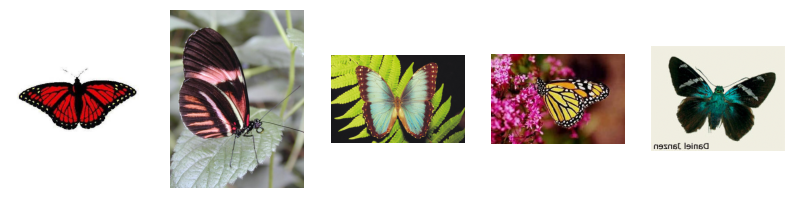

In [19]:
fig = plt.figure(figsize=(10, 10))

image_range = seen_images[0:5]

for i in range(len(image_range)):
    try:
        ax = fig.add_subplot(1, 5, i + 1)
        img = image_range[i]

        if img.max() > 1:
            img = img / 255.0
        ax.imshow(img)
        ax.axis('off')
    except:
        break
plt.show()

### Time to Build the Network

Creating an augmentation layer

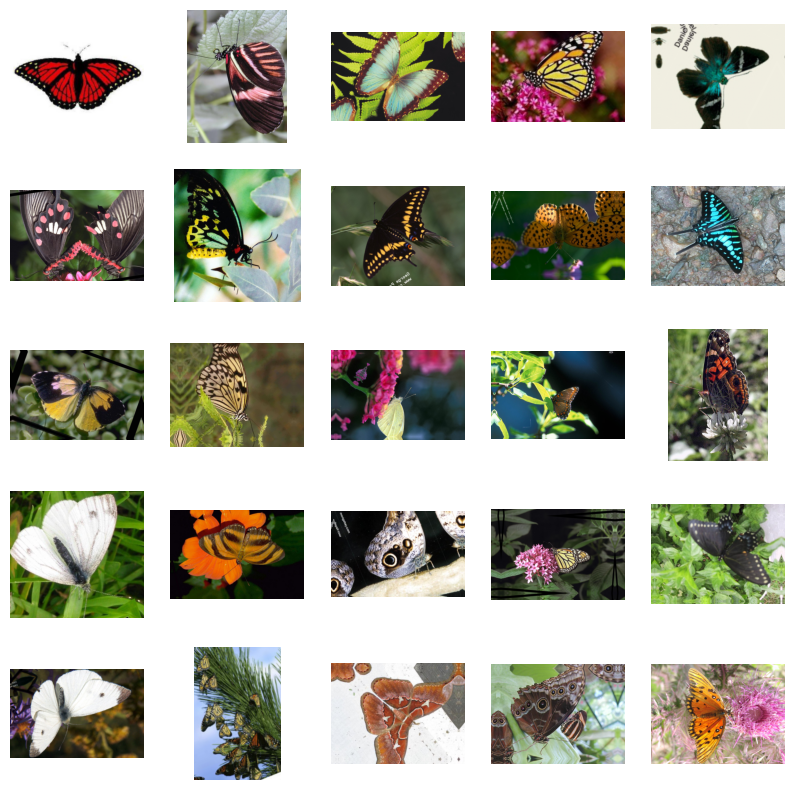

In [20]:
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
])

fig = plt.figure(figsize=(10, 10))
image_range = seen_images[0:50]
for i in range(len(image_range)):
    try:
        ax = fig.add_subplot(5, 5, i + 1)
        img = image_range[i]

        if img.max() > 1:
            img = img / 255.0
        ax.imshow(data_augmentation(img))
        ax.axis('off')
    except:
        break

plt.show()

Doing some normalisation for model training

In [21]:
seen_train_X = seen_train_X.astype('float32') / 255.0
seen_test_X = seen_test_X.astype('float32') / 255.0
unseen_train_X = unseen_train_X.astype('float32') / 255.0
unseen_test_X = unseen_test_X.astype('float32') / 255.0

In [37]:
unseen_train_X

array([[[[0.21960784, 0.23137255, 0.23921569],
         [0.20784314, 0.22352941, 0.22745098],
         [0.19215687, 0.20784314, 0.21176471],
         ...,
         [0.5764706 , 0.56078434, 0.5647059 ],
         [0.5372549 , 0.5176471 , 0.53333336],
         [0.5137255 , 0.49411765, 0.50980395]],

        [[0.30588236, 0.30980393, 0.31764707],
         [0.28235295, 0.28627452, 0.29411766],
         [0.24705882, 0.2509804 , 0.25882354],
         ...,
         [0.5529412 , 0.54901963, 0.54901963],
         [0.52156866, 0.5137255 , 0.5176471 ],
         [0.4745098 , 0.46666667, 0.47058824]],

        [[0.3647059 , 0.3647059 , 0.36862746],
         [0.34509805, 0.34901962, 0.34901962],
         [0.3137255 , 0.31764707, 0.31764707],
         ...,
         [0.5411765 , 0.5372549 , 0.53333336],
         [0.5137255 , 0.5137255 , 0.5058824 ],
         [0.45882353, 0.45490196, 0.4509804 ]],

        ...,

        [[0.70980394, 0.6862745 , 0.7019608 ],
         [0.6666667 , 0.64705884, 0.6627451 ]

In [28]:
def residual_block(x, filters, downsample=False):
    shortcut = x

    # First conv block
    x = layers.Conv2D(filters, (3, 3), padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    # Second conv block (optionally downsampling)
    if downsample:
        x = layers.Conv2D(filters, (3, 3), strides=2, padding='same', use_bias=False)(x)
    else:
        x = layers.Conv2D(filters, (3, 3), padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)

    # Shortcut connection
    if downsample or shortcut.shape[-1] != filters:
        shortcut = layers.Conv2D(filters, (1, 1), strides=(2 if downsample else 1),
                                 padding='same', use_bias=False)(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)

    # Residual addition
    x = layers.Add()([x, shortcut])
    x = layers.Activation('relu')(x)
    return x


input_layer = layers.Input(shape=(256, 256, 3), name='input_image')

# x = layers.Resizing(256, 256)(input_layer)
# x = layers.RandomFlip("horizontal_and_vertical")(x)
# x = layers.RandomRotation(0.2)(x)
# x = layers.RandomZoom(0.2)(x)

x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(input_layer)
x = layers.Activation('relu')(x)
x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.SpatialDropout2D(0.1)(x)
x = layers.MaxPooling2D()(x)

x = residual_block(x, 32, downsample=True)
x = layers.MaxPooling2D()(x)
x = residual_block(x, 64, downsample=True)
x = layers.MaxPooling2D()(x)
x = residual_block(x, 128, downsample=True)
x = layers.MaxPooling2D()(x)

x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(64, activation='relu')(x)
x_1 = layers.Dense(64, activation='relu')(x)
output_1 = layers.Dense(13, activation='softmax', name='species_pred')(x_1)
x_2 = layers.Dense(64, activation='relu')(x)
output_2 = layers.Dense(5, activation='softmax', name='endangered_pred')(x_2)

model = keras.Model(inputs=input_layer, outputs=[output_1, output_2])   

model.summary()

from tensorflow.keras.utils import plot_model

# Assuming you've already built the model:
plot_model(model, to_file="resnet_custom_model.png", show_shapes=True, show_layer_names=True)

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_image         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 256, 256,  │        448 │ input_image[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_7        │ (None, 256, 256,  │          0 │ conv2d_12[0][0]   │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_13 (Conv2D)  │ (None, 256, 256,  │      2,320 │ activation_7[0][… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │         64 │ conv2d_13[0][0]   │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_dropout2d_1 │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (SpatialDropout2D)  │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 128, 128,  │          0 │ spatial_dropout2… │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_14 (Conv2D)  │ (None, 128, 128,  │      4,608 │ max_pooling2d_4[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_14[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_8        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_15 (Conv2D)  │ (None, 64, 64,    │      9,216 │ activation_8[0][… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_16 (Conv2D)  │ (None, 64, 64,    │        512 │ max_pooling2d_4[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        128 │ conv2d_15[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        128 │ conv2d_16[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 64, 64,    │          0 │ batch_normalizat… │
│                     │ 32)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_9        │ (None, 64, 64,    │          0 │ add_3[0][0]       │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 32, 32,    │          0 │ activation_9[0][

 Total params: 324,322 (1.24 MB)

 Trainable params: 322,946 (1.23 MB)

 Non-trainable params: 1,376 (5.38 KB)

You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.


In [24]:
endangered_labelled_test_Y.max()

1.0

Initial training

In [29]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate = 0.0001), loss = {
	'species_pred': 'categorical_crossentropy',
	'endangered_pred': 'categorical_crossentropy'
	}, loss_weights = {
	'species_pred': 1.0,
	'endangered_pred': 1.0
}, metrics = ['accuracy', 'accuracy'], jit_compile=False)

history = model.fit(
	seen_train_X,
	[species_labelled_train_Y, endangered_labelled_train_Y],
	epochs=20,
	batch_size=32,
	validation_data=(seen_test_X, [species_labelled_test_Y, endangered_labelled_test_Y]),
	verbose=1
)

Epoch 1/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - endangered_pred_accuracy: 0.2178 - endangered_pred_loss: 1.7767 - loss: 5.1210 - species_pred_accuracy: 0.0798 - species_pred_loss: 3.3398 - val_endangered_pred_accuracy: 0.2129 - val_endangered_pred_loss: 1.5886 - val_loss: 4.1338 - val_species_pred_accuracy: 0.0516 - val_species_pred_loss: 2.5453
Epoch 2/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - endangered_pred_accuracy: 0.4210 - endangered_pred_loss: 1.3990 - loss: 3.8846 - species_pred_accuracy: 0.1379 - species_pred_loss: 2.4851 - val_endangered_pred_accuracy: 0.1355 - val_endangered_pred_loss: 1.6123 - val_loss: 4.1440 - val_species_pred_accuracy: 0.0839 - val_species_pred_loss: 2.5321
Epoch 3/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - endangered_pred_accuracy: 0.4842 - endangered_pred_loss: 1.3363 - loss: 3.5803 - species_pred_accuracy: 0.2826 - species_pred_loss: 2.2423 - val_endangered_pred_accuracy: 0.1161 - val_endangered_pred_loss: 1.6665 - val_loss: 4.1965 - val_specie

Regenerating pseudo labels for another iteration

In [45]:
pseudo_images = []
species_pseudo_labels = []
endangered_pseudo_labels = []

for i in range(len(unseen_train_X)):
    species_prediction, endangered_prediction = model.predict(unseen_train_X[i:i+1])

    species_task = tf.reduce_max(species_prediction, axis=1)
    endangered_task = tf.reduce_max(endangered_prediction, axis=1)

    mask = tf.logical_and(species_task >= 0.7, endangered_task >= 0.7)

    selected_images = tf.boolean_mask(unseen_train_X[i:i+1], mask)
    selected_species = tf.boolean_mask(species_prediction, mask)
    selected_endangered = tf.boolean_mask(endangered_prediction, mask)

    pseudo_images.append(selected_images)
    species_pseudo_labels.append(selected_species)
    endangered_pseudo_labels.append(selected_endangered)

pseudo_images = tf.concat(pseudo_images, axis=0)
species_pseudo_labels = tf.concat(species_pseudo_labels, axis=0)
endangered_pseudo_labels = tf.concat(endangered_pseudo_labels, axis=0)

combined_images = tf.concat([seen_train_X, pseudo_images], axis=0)
combined_species_labels = tf.concat([species_labelled_train_Y, species_pseudo_labels], axis=0)
combined_endangered_labels = tf.concat([endangered_labelled_train_Y, endangered_pseudo_labels], axis=0)


combine_dataset = tf.data.Dataset.from_tensor_slices(
    (combined_images, {'species_pred': combined_species_labels, 'endangered_pred': combined_endangered_labels})
)
combine_dataset = combine_dataset.shuffle(1000).batch(32)

print(len(species_pseudo_labels))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━

In [46]:
model.fit(
    combine_dataset,
    epochs=10,
    validation_data=(seen_test_X, [species_labelled_test_Y, endangered_labelled_test_Y]),
)

Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - endangered_pred_accuracy: 0.7511 - endangered_pred_loss: 0.7208 - loss: 1.6927 - species_pred_accuracy: 0.8081 - species_pred_loss: 0.9725 - val_endangered_pred_accuracy: 0.2710 - val_endangered_pred_loss: 1.5216 - val_loss: 3.8785 - val_species_pred_accuracy: 0.2710 - val_species_pred_loss: 2.3568
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step - endangered_pred_accuracy: 0.7699 - endangered_pred_loss: 0.6774 - loss: 1.5837 - species_pred_accuracy: 0.8321 - species_pred_loss: 0.9057 - val_endangered_pred_accuracy: 0.2968 - val_endangered_pred_loss: 1.4671 - val_loss: 3.7712 - val_species_pred_accuracy: 0.2774 - val_species_pred_loss: 2.3038
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - endangered_pred_accuracy: 0.7632 - endangered_pred_loss: 0.6964 - loss: 1.6245 - species_pred_accuracy: 0.8102 - species_pred_loss: 0.9285 - val_endangered_pred_accuracy: 0.3355 - val_endangered_pred_loss: 1.4356 - val_loss: 3.6399 - val_specie

Second iteration

In [ ]:
pseudo_images = []
species_pseudo_labels = []
endangered_pseudo_labels = []

for i in range(len(unseen_train_X)):
    species_prediction, endangered_prediction = model.predict(unseen_train_X[i:i+1])

    species_task = tf.reduce_max(species_prediction, axis=1)
    endangered_task = tf.reduce_max(endangered_prediction, axis=1)

    mask = tf.logical_and(species_task >= 0.7, endangered_task >= 0.7)

    selected_images = tf.boolean_mask(unseen_train_X[i:i+1], mask)
    selected_species = tf.boolean_mask(species_prediction, mask)
    selected_endangered = tf.boolean_mask(endangered_prediction, mask)

    pseudo_images.append(selected_images)
    species_pseudo_labels.append(selected_species)
    endangered_pseudo_labels.append(selected_endangered)

pseudo_images = tf.concat(pseudo_images, axis=0)
species_pseudo_labels = tf.concat(species_pseudo_labels, axis=0)
endangered_pseudo_labels = tf.concat(endangered_pseudo_labels, axis=0)

combined_images = tf.concat([seen_train_X, pseudo_images], axis=0)
combined_species_labels = tf.concat([species_labelled_train_Y, species_pseudo_labels], axis=0)
combined_endangered_labels = tf.concat([endangered_labelled_train_Y, endangered_pseudo_labels], axis=0)


combine_dataset = tf.data.Dataset.from_tensor_slices(
    (combined_images, {'species_pred': combined_species_labels, 'endangered_pred': combined_endangered_labels})
)
combine_dataset = combine_dataset.shuffle(1000).batch(32)

print(len(species_pseudo_labels))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━

In [48]:
model.fit(
    combine_dataset,
    epochs = 10,
    validation_data = (seen_test_X, [species_labelled_test_Y, endangered_labelled_test_Y]),
    batch_size = 32
)

Epoch 1/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - endangered_pred_accuracy: 0.9252 - endangered_pred_loss: 0.4028 - loss: 0.9478 - species_pred_accuracy: 0.9144 - species_pred_loss: 0.5450 - val_endangered_pred_accuracy: 0.5032 - val_endangered_pred_loss: 1.2754 - val_loss: 3.1872 - val_species_pred_accuracy: 0.3613 - val_species_pred_loss: 1.9227
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - endangered_pred_accuracy: 0.9097 - endangered_pred_loss: 0.4211 - loss: 0.8999 - species_pred_accuracy: 0.9520 - species_pred_loss: 0.4788 - val_endangered_pred_accuracy: 0.5226 - val_endangered_pred_loss: 1.2544 - val_loss: 3.1291 - val_species_pred_accuracy: 0.3484 - val_species_pred_loss: 1.8873
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - endangered_pred_accuracy: 0.9001 - endangered_pred_loss: 0.3829 - loss: 0.8721 - species_pred_accuracy: 0.9275 - species_pred_loss: 0.4892 - val_endangered_pred_accuracy: 0.4581 - val_endangered_pred_loss: 1.3479 - val_loss: 3.2541 - val_specie

In [50]:
pseudo_images = []
species_pseudo_labels = []
endangered_pseudo_labels = []

for i in range(len(unseen_train_X)):
    species_prediction, endangered_prediction = model.predict(unseen_train_X[i:i+1])

    species_task = tf.reduce_max(species_prediction, axis=1)
    endangered_task = tf.reduce_max(endangered_prediction, axis=1)

    mask = tf.logical_and(species_task >= 0.8, endangered_task >= 0.8)

    selected_images = tf.boolean_mask(unseen_train_X[i:i+1], mask)
    selected_species = tf.boolean_mask(species_prediction, mask)
    selected_endangered = tf.boolean_mask(endangered_prediction, mask)

    pseudo_images.append(selected_images)
    species_pseudo_labels.append(selected_species)
    endangered_pseudo_labels.append(selected_endangered)

pseudo_images = tf.concat(pseudo_images, axis=0)
species_pseudo_labels = tf.concat(species_pseudo_labels, axis=0)
endangered_pseudo_labels = tf.concat(endangered_pseudo_labels, axis=0)

combined_images = tf.concat([seen_train_X, pseudo_images], axis=0)
combined_species_labels = tf.concat([species_labelled_train_Y, species_pseudo_labels], axis=0)
combined_endangered_labels = tf.concat([endangered_labelled_train_Y, endangered_pseudo_labels], axis=0)


combine_dataset = tf.data.Dataset.from_tensor_slices(
    (combined_images, {'species_pred': combined_species_labels, 'endangered_pred': combined_endangered_labels})
)
combine_dataset = combine_dataset.shuffle(1000).batch(32)

print(len(species_pseudo_labels))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━

Third Iteration

In [ ]:
model.fit(
    combine_dataset,
    epochs = 5,
    validation_data = (seen_test_X, [species_labelled_test_Y, endangered_labelled_test_Y]),
    batch_size = 16
)

Epoch 1/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - endangered_pred_accuracy: 0.9711 - endangered_pred_loss: 0.2193 - loss: 0.4998 - species_pred_accuracy: 0.9796 - species_pred_loss: 0.2807 - val_endangered_pred_accuracy: 0.5419 - val_endangered_pred_loss: 1.3262 - val_loss: 3.1793 - val_species_pred_accuracy: 0.3484 - val_species_pred_loss: 1.8994
Epoch 2/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - endangered_pred_accuracy: 0.9376 - endangered_pred_loss: 0.2586 - loss: 0.5563 - species_pred_accuracy: 0.9672 - species_pred_loss: 0.2977 - val_endangered_pred_accuracy: 0.5290 - val_endangered_pred_loss: 1.2786 - val_loss: 3.0661 - val_species_pred_accuracy: 0.4000 - val_species_pred_loss: 1.8304
Epoch 3/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - endangered_pred_accuracy: 0.9723 - endangered_pred_loss: 0.1978 - loss: 0.4541 - species_pred_accuracy: 0.9731 - species_pred_loss: 0.2566 - val_endangered_pred_accuracy: 0.4968 - val_endangered_pred_loss: 1.3678 - val_loss: 3.3163 - val_specie

In [52]:
pseudo_images = []
species_pseudo_labels = []
endangered_pseudo_labels = []

for i in range(len(unseen_train_X)):
    species_prediction, endangered_prediction = model.predict(unseen_train_X[i:i+1])

    species_task = tf.reduce_max(species_prediction, axis=1)
    endangered_task = tf.reduce_max(endangered_prediction, axis=1)

    mask = tf.logical_and(species_task >= 0.8, endangered_task >= 0.8)

    selected_images = tf.boolean_mask(unseen_train_X[i:i+1], mask)
    selected_species = tf.boolean_mask(species_prediction, mask)
    selected_endangered = tf.boolean_mask(endangered_prediction, mask)

    pseudo_images.append(selected_images)
    species_pseudo_labels.append(selected_species)
    endangered_pseudo_labels.append(selected_endangered)

pseudo_images = tf.concat(pseudo_images, axis=0)
species_pseudo_labels = tf.concat(species_pseudo_labels, axis=0)
endangered_pseudo_labels = tf.concat(endangered_pseudo_labels, axis=0)

combined_images = tf.concat([seen_train_X, pseudo_images], axis=0)
combined_species_labels = tf.concat([species_labelled_train_Y, species_pseudo_labels], axis=0)
combined_endangered_labels = tf.concat([endangered_labelled_train_Y, endangered_pseudo_labels], axis=0)


combine_dataset = tf.data.Dataset.from_tensor_slices(
    (combined_images, {'species_pred': combined_species_labels, 'endangered_pred': combined_endangered_labels})
)
combine_dataset = combine_dataset.shuffle(1000).batch(32)

print(len(species_pseudo_labels))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━

In [ ]:
model.fit(
    combine_dataset,
    epochs = 5,
    validation_data = (seen_test_X, [species_labelled_test_Y, endangered_labelled_test_Y]),
    batch_size = 16
)

Epoch 1/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - endangered_pred_accuracy: 0.9927 - endangered_pred_loss: 0.1291 - loss: 0.3131 - species_pred_accuracy: 0.9840 - species_pred_loss: 0.1840 - val_endangered_pred_accuracy: 0.5742 - val_endangered_pred_loss: 1.3923 - val_loss: 3.2688 - val_species_pred_accuracy: 0.4000 - val_species_pred_loss: 1.9342
Epoch 2/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - endangered_pred_accuracy: 0.9914 - endangered_pred_loss: 0.1324 - loss: 0.3126 - species_pred_accuracy: 0.9853 - species_pred_loss: 0.1802 - val_endangered_pred_accuracy: 0.5097 - val_endangered_pred_loss: 1.4530 - val_loss: 3.3483 - val_species_pred_accuracy: 0.3935 - val_species_pred_loss: 1.9437
Epoch 3/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - endangered_pred_accuracy: 0.9733 - endangered_pred_loss: 0.1323 - loss: 0.2867 - species_pred_accuracy: 0.9922 - species_pred_loss: 0.1546 - val_endangered_pred_accuracy: 0.5226 - val_endangered_pred_loss: 1.4564 - val_loss: 3.3384 - val_specie

In [54]:
pseudo_images = []
species_pseudo_labels = []
endangered_pseudo_labels = []

for i in range(len(unseen_train_X)):
    species_prediction, endangered_prediction = model.predict(unseen_train_X[i:i+1])

    species_task = tf.reduce_max(species_prediction, axis=1)
    endangered_task = tf.reduce_max(endangered_prediction, axis=1)

    mask = tf.logical_and(species_task >= 0.8, endangered_task >= 0.8)

    selected_images = tf.boolean_mask(unseen_train_X[i:i+1], mask)
    selected_species = tf.boolean_mask(species_prediction, mask)
    selected_endangered = tf.boolean_mask(endangered_prediction, mask)

    pseudo_images.append(selected_images)
    species_pseudo_labels.append(selected_species)
    endangered_pseudo_labels.append(selected_endangered)

pseudo_images = tf.concat(pseudo_images, axis=0)
species_pseudo_labels = tf.concat(species_pseudo_labels, axis=0)
endangered_pseudo_labels = tf.concat(endangered_pseudo_labels, axis=0)

combined_images = tf.concat([seen_train_X, pseudo_images], axis=0)
combined_species_labels = tf.concat([species_labelled_train_Y, species_pseudo_labels], axis=0)
combined_endangered_labels = tf.concat([endangered_labelled_train_Y, endangered_pseudo_labels], axis=0)


combine_dataset = tf.data.Dataset.from_tensor_slices(
    (combined_images, {'species_pred': combined_species_labels, 'endangered_pred': combined_endangered_labels})
)
combine_dataset = combine_dataset.shuffle(1000).batch(32)

print(len(species_pseudo_labels))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━

In [ ]:
model.fit(
    combine_dataset,
    epochs = 5,
    validation_data = (seen_test_X, [species_labelled_test_Y, endangered_labelled_test_Y]),
    batch_size = 16
)

Epoch 1/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - endangered_pred_accuracy: 0.9841 - endangered_pred_loss: 0.0926 - loss: 0.2255 - species_pred_accuracy: 0.9899 - species_pred_loss: 0.1339 - val_endangered_pred_accuracy: 0.5097 - val_endangered_pred_loss: 1.4702 - val_loss: 3.4339 - val_species_pred_accuracy: 0.3871 - val_species_pred_loss: 2.0182
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - endangered_pred_accuracy: 0.9911 - endangered_pred_loss: 0.0919 - loss: 0.2150 - species_pred_accuracy: 0.9976 - species_pred_loss: 0.1232 - val_endangered_pred_accuracy: 0.5290 - val_endangered_pred_loss: 1.5030 - val_loss: 3.5006 - val_species_pred_accuracy: 0.3742 - val_species_pred_loss: 2.0476
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - endangered_pred_accuracy: 0.9960 - endangered_pred_loss: 0.0728 - loss: 0.1874 - species_pred_accuracy: 0.9956 - species_pred_loss: 0.1149 - val_endangered_pred_accuracy: 0.5484 - val_endangered_pred_loss: 1.4768 - val_loss: 3.5830 - val_specie

In [56]:
pseudo_images = []
species_pseudo_labels = []
endangered_pseudo_labels = []

for i in range(len(unseen_train_X)):
    species_prediction, endangered_prediction = model.predict(unseen_train_X[i:i+1])

    species_task = tf.reduce_max(species_prediction, axis=1)
    endangered_task = tf.reduce_max(endangered_prediction, axis=1)

    mask = tf.logical_and(species_task >= 0.8, endangered_task >= 0.8)

    selected_images = tf.boolean_mask(unseen_train_X[i:i+1], mask)
    selected_species = tf.boolean_mask(species_prediction, mask)
    selected_endangered = tf.boolean_mask(endangered_prediction, mask)

    pseudo_images.append(selected_images)
    species_pseudo_labels.append(selected_species)
    endangered_pseudo_labels.append(selected_endangered)

pseudo_images = tf.concat(pseudo_images, axis=0)
species_pseudo_labels = tf.concat(species_pseudo_labels, axis=0)
endangered_pseudo_labels = tf.concat(endangered_pseudo_labels, axis=0)

combined_images = tf.concat([seen_train_X, pseudo_images], axis=0)
combined_species_labels = tf.concat([species_labelled_train_Y, species_pseudo_labels], axis=0)
combined_endangered_labels = tf.concat([endangered_labelled_train_Y, endangered_pseudo_labels], axis=0)


combine_dataset = tf.data.Dataset.from_tensor_slices(
    (combined_images, {'species_pred': combined_species_labels, 'endangered_pred': combined_endangered_labels})
)
combine_dataset = combine_dataset.shuffle(1000).batch(32)

print(len(species_pseudo_labels))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━

In [ ]:
model.fit(
    combine_dataset,
    epochs = 5,
    validation_data = (seen_test_X, [species_labelled_test_Y, endangered_labelled_test_Y]),
    batch_size = 16
)

Epoch 1/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - endangered_pred_accuracy: 0.9935 - endangered_pred_loss: 0.0688 - loss: 0.1703 - species_pred_accuracy: 0.9946 - species_pred_loss: 0.1016 - val_endangered_pred_accuracy: 0.4323 - val_endangered_pred_loss: 1.7519 - val_loss: 3.7768 - val_species_pred_accuracy: 0.4000 - val_species_pred_loss: 2.0830
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - endangered_pred_accuracy: 0.9969 - endangered_pred_loss: 0.0668 - loss: 0.1682 - species_pred_accuracy: 0.9963 - species_pred_loss: 0.1014 - val_endangered_pred_accuracy: 0.5097 - val_endangered_pred_loss: 1.5711 - val_loss: 3.5875 - val_species_pred_accuracy: 0.4129 - val_species_pred_loss: 2.0804
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - endangered_pred_accuracy: 0.9904 - endangered_pred_loss: 0.0644 - loss: 0.1507 - species_pred_accuracy: 0.9934 - species_pred_loss: 0.0863 - val_endangered_pred_accuracy: 0.5613 - val_endangered_pred_loss: 1.8108 - val_loss: 4.0137 - val_specie

In [58]:
pseudo_images = []
species_pseudo_labels = []
endangered_pseudo_labels = []

for i in range(len(unseen_train_X)):
    species_prediction, endangered_prediction = model.predict(unseen_train_X[i:i+1])

    species_task = tf.reduce_max(species_prediction, axis=1)
    endangered_task = tf.reduce_max(endangered_prediction, axis=1)

    mask = tf.logical_and(species_task >= 0.8, endangered_task >= 0.8)

    selected_images = tf.boolean_mask(unseen_train_X[i:i+1], mask)
    selected_species = tf.boolean_mask(species_prediction, mask)
    selected_endangered = tf.boolean_mask(endangered_prediction, mask)

    pseudo_images.append(selected_images)
    species_pseudo_labels.append(selected_species)
    endangered_pseudo_labels.append(selected_endangered)

pseudo_images = tf.concat(pseudo_images, axis=0)
species_pseudo_labels = tf.concat(species_pseudo_labels, axis=0)
endangered_pseudo_labels = tf.concat(endangered_pseudo_labels, axis=0)

combined_images = tf.concat([seen_train_X, pseudo_images], axis=0)
combined_species_labels = tf.concat([species_labelled_train_Y, species_pseudo_labels], axis=0)
combined_endangered_labels = tf.concat([endangered_labelled_train_Y, endangered_pseudo_labels], axis=0)


combine_dataset = tf.data.Dataset.from_tensor_slices(
    (combined_images, {'species_pred': combined_species_labels, 'endangered_pred': combined_endangered_labels})
)
combine_dataset = combine_dataset.shuffle(1000).batch(32)

print(len(species_pseudo_labels))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━

In [ ]:
model.fit(
    combine_dataset,
    epochs = 5,
    validation_data = (seen_test_X, [species_labelled_test_Y, endangered_labelled_test_Y]),
    batch_size = 8
)

Epoch 1/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - endangered_pred_accuracy: 0.9947 - endangered_pred_loss: 0.0516 - loss: 0.1430 - species_pred_accuracy: 0.9947 - species_pred_loss: 0.0914 - val_endangered_pred_accuracy: 0.5355 - val_endangered_pred_loss: 1.5511 - val_loss: 3.6878 - val_species_pred_accuracy: 0.3677 - val_species_pred_loss: 2.1146
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - endangered_pred_accuracy: 0.9980 - endangered_pred_loss: 0.0442 - loss: 0.1418 - species_pred_accuracy: 0.9907 - species_pred_loss: 0.0976 - val_endangered_pred_accuracy: 0.5677 - val_endangered_pred_loss: 1.7213 - val_loss: 3.8497 - val_species_pred_accuracy: 0.3742 - val_species_pred_loss: 2.0990
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - endangered_pred_accuracy: 0.9974 - endangered_pred_loss: 0.0477 - loss: 0.1290 - species_pred_accuracy: 0.9955 - species_pred_loss: 0.0813 - val_endangered_pred_accuracy: 0.5097 - val_endangered_pred_loss: 1.5353 - val_loss: 3.6440 - val_specie

In [60]:
pseudo_images = []
species_pseudo_labels = []
endangered_pseudo_labels = []

for i in range(len(unseen_train_X)):
    species_prediction, endangered_prediction = model.predict(unseen_train_X[i:i+1])

    species_task = tf.reduce_max(species_prediction, axis=1)
    endangered_task = tf.reduce_max(endangered_prediction, axis=1)

    mask = tf.logical_and(species_task >= 0.8, endangered_task >= 0.8)

    selected_images = tf.boolean_mask(unseen_train_X[i:i+1], mask)
    selected_species = tf.boolean_mask(species_prediction, mask)
    selected_endangered = tf.boolean_mask(endangered_prediction, mask)

    pseudo_images.append(selected_images)
    species_pseudo_labels.append(selected_species)
    endangered_pseudo_labels.append(selected_endangered)

pseudo_images = tf.concat(pseudo_images, axis=0)
species_pseudo_labels = tf.concat(species_pseudo_labels, axis=0)
endangered_pseudo_labels = tf.concat(endangered_pseudo_labels, axis=0)

combined_images = tf.concat([seen_train_X, pseudo_images], axis=0)
combined_species_labels = tf.concat([species_labelled_train_Y, species_pseudo_labels], axis=0)
combined_endangered_labels = tf.concat([endangered_labelled_train_Y, endangered_pseudo_labels], axis=0)


combine_dataset = tf.data.Dataset.from_tensor_slices(
    (combined_images, {'species_pred': combined_species_labels, 'endangered_pred': combined_endangered_labels})
)
combine_dataset = combine_dataset.shuffle(1000).batch(32)

print(len(species_pseudo_labels))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━

In [ ]:
model.fit(
    combine_dataset,
    epochs = 5,
    validation_data = (seen_test_X, [species_labelled_test_Y, endangered_labelled_test_Y]),
    batch_size = 8
)

Epoch 1/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - endangered_pred_accuracy: 0.9907 - endangered_pred_loss: 0.0738 - loss: 0.1553 - species_pred_accuracy: 0.9976 - species_pred_loss: 0.0826 - val_endangered_pred_accuracy: 0.5290 - val_endangered_pred_loss: 1.6647 - val_loss: 3.8444 - val_species_pred_accuracy: 0.3871 - val_species_pred_loss: 2.1894
Epoch 2/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - endangered_pred_accuracy: 0.9931 - endangered_pred_loss: 0.0775 - loss: 0.1737 - species_pred_accuracy: 0.9919 - species_pred_loss: 0.0962 - val_endangered_pred_accuracy: 0.4581 - val_endangered_pred_loss: 1.9056 - val_loss: 4.2453 - val_species_pred_accuracy: 0.4000 - val_species_pred_loss: 2.3274
Epoch 3/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - endangered_pred_accuracy: 0.9951 - endangered_pred_loss: 0.0704 - loss: 0.1528 - species_pred_accuracy: 0.9979 - species_pred_loss: 0.0827 - val_endangered_pred_accuracy: 0.5484 - val_endangered_pred_loss: 1.5197 - val_loss: 3.7508 - val_specie

In [62]:
pseudo_images = []
species_pseudo_labels = []
endangered_pseudo_labels = []

for i in range(len(unseen_train_X)):
    species_prediction, endangered_prediction = model.predict(unseen_train_X[i:i+1])

    species_task = tf.reduce_max(species_prediction, axis=1)
    endangered_task = tf.reduce_max(endangered_prediction, axis=1)

    mask = tf.logical_and(species_task >= 0.8, endangered_task >= 0.8)

    selected_images = tf.boolean_mask(unseen_train_X[i:i+1], mask)
    selected_species = tf.boolean_mask(species_prediction, mask)
    selected_endangered = tf.boolean_mask(endangered_prediction, mask)

    pseudo_images.append(selected_images)
    species_pseudo_labels.append(selected_species)
    endangered_pseudo_labels.append(selected_endangered)

pseudo_images = tf.concat(pseudo_images, axis=0)
species_pseudo_labels = tf.concat(species_pseudo_labels, axis=0)
endangered_pseudo_labels = tf.concat(endangered_pseudo_labels, axis=0)

combined_images = tf.concat([seen_train_X, pseudo_images], axis=0)
combined_species_labels = tf.concat([species_labelled_train_Y, species_pseudo_labels], axis=0)
combined_endangered_labels = tf.concat([endangered_labelled_train_Y, endangered_pseudo_labels], axis=0)


combine_dataset = tf.data.Dataset.from_tensor_slices(
    (combined_images, {'species_pred': combined_species_labels, 'endangered_pred': combined_endangered_labels})
)
combine_dataset = combine_dataset.shuffle(1000).batch(32)

print(len(species_pseudo_labels))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━

In [ ]:
model.fit(
    combine_dataset,
    epochs = 5,
    validation_data = (seen_test_X, [species_labelled_test_Y, endangered_labelled_test_Y]),
    batch_size = 8
)

Epoch 1/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - endangered_pred_accuracy: 0.9941 - endangered_pred_loss: 0.0559 - loss: 0.1253 - species_pred_accuracy: 0.9935 - species_pred_loss: 0.0693 - val_endangered_pred_accuracy: 0.5226 - val_endangered_pred_loss: 1.7265 - val_loss: 3.9381 - val_species_pred_accuracy: 0.4194 - val_species_pred_loss: 2.1984
Epoch 2/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - endangered_pred_accuracy: 0.9930 - endangered_pred_loss: 0.0635 - loss: 0.1380 - species_pred_accuracy: 0.9994 - species_pred_loss: 0.0747 - val_endangered_pred_accuracy: 0.5613 - val_endangered_pred_loss: 2.0173 - val_loss: 4.2831 - val_species_pred_accuracy: 0.4000 - val_species_pred_loss: 2.2653
Epoch 3/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - endangered_pred_accuracy: 0.9985 - endangered_pred_loss: 0.0535 - loss: 0.1235 - species_pred_accuracy: 0.9969 - species_pred_loss: 0.0699 - val_endangered_pred_accuracy: 0.5419 - val_endangered_pred_loss: 1.7066 - val_loss: 3.9424 - val_specie

In [64]:
pseudo_images = []
species_pseudo_labels = []
endangered_pseudo_labels = []

for i in range(len(unseen_train_X)):
    species_prediction, endangered_prediction = model.predict(unseen_train_X[i:i+1])

    species_task = tf.reduce_max(species_prediction, axis=1)
    endangered_task = tf.reduce_max(endangered_prediction, axis=1)

    mask = tf.logical_and(species_task >= 0.8, endangered_task >= 0.8)

    selected_images = tf.boolean_mask(unseen_train_X[i:i+1], mask)
    selected_species = tf.boolean_mask(species_prediction, mask)
    selected_endangered = tf.boolean_mask(endangered_prediction, mask)

    pseudo_images.append(selected_images)
    species_pseudo_labels.append(selected_species)
    endangered_pseudo_labels.append(selected_endangered)

pseudo_images = tf.concat(pseudo_images, axis=0)
species_pseudo_labels = tf.concat(species_pseudo_labels, axis=0)
endangered_pseudo_labels = tf.concat(endangered_pseudo_labels, axis=0)

combined_images = tf.concat([seen_train_X, pseudo_images], axis=0)
combined_species_labels = tf.concat([species_labelled_train_Y, species_pseudo_labels], axis=0)
combined_endangered_labels = tf.concat([endangered_labelled_train_Y, endangered_pseudo_labels], axis=0)


combine_dataset = tf.data.Dataset.from_tensor_slices(
    (combined_images, {'species_pred': combined_species_labels, 'endangered_pred': combined_endangered_labels})
)
combine_dataset = combine_dataset.shuffle(1000).batch(32)

print(len(species_pseudo_labels))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━

In [65]:
model.fit(
    combine_dataset,
    epochs = 5,
    validation_data = (seen_test_X, [species_labelled_test_Y, endangered_labelled_test_Y]),
    batch_size = 8
)

Epoch 1/5
27/27 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - endangered_pred_accuracy: 0.9875 - endangered_pred_loss: 0.0622 - loss: 0.1277 - species_pred_accuracy: 0.9952 - species_pred_loss: 0.0654 - val_endangered_pred_accuracy: 0.5548 - val_endangered_pred_loss: 2.0427 - val_loss: 4.3267 - val_species_pred_accuracy: 0.3613 - val_species_pred_loss: 2.2660
Epoch 2/5
27/27 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - endangered_pred_accuracy: 0.9992 - endangered_pred_loss: 0.0415 - loss: 0.1228 - species_pred_accuracy: 0.9980 - species_pred_loss: 0.0813 - val_endangered_pred_accuracy: 0.5548 - val_endangered_pred_loss: 1.7439 - val_loss: 3.9849 - val_species_pred_accuracy: 0.4065 - val_species_pred_loss: 2.2514
Epoch 3/5
27/27 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - endangered_pred_accuracy: 0.9939 - endangered_pred_loss: 0.0492 - loss: 0.1261 - species_pred_accuracy: 0.9918 - species_pred_loss: 0.0768 - val_endangered_pred_accuracy: 0.5419 - val_endangered_pred_loss: 2.2110 - val_loss: 4.5027 - val_species_p

In [66]:
pseudo_images = []
species_pseudo_labels = []
endangered_pseudo_labels = []

for i in range(len(unseen_train_X)):
    species_prediction, endangered_prediction = model.predict(unseen_train_X[i:i+1])

    species_task = tf.reduce_max(species_prediction, axis=1)
    endangered_task = tf.reduce_max(endangered_prediction, axis=1)

    mask = tf.logical_and(species_task >= 0.8, endangered_task >= 0.8)

    selected_images = tf.boolean_mask(unseen_train_X[i:i+1], mask)
    selected_species = tf.boolean_mask(species_prediction, mask)
    selected_endangered = tf.boolean_mask(endangered_prediction, mask)

    pseudo_images.append(selected_images)
    species_pseudo_labels.append(selected_species)
    endangered_pseudo_labels.append(selected_endangered)

pseudo_images = tf.concat(pseudo_images, axis=0)
species_pseudo_labels = tf.concat(species_pseudo_labels, axis=0)
endangered_pseudo_labels = tf.concat(endangered_pseudo_labels, axis=0)

combined_images = tf.concat([seen_train_X, pseudo_images], axis=0)
combined_species_labels = tf.concat([species_labelled_train_Y, species_pseudo_labels], axis=0)
combined_endangered_labels = tf.concat([endangered_labelled_train_Y, endangered_pseudo_labels], axis=0)


combine_dataset = tf.data.Dataset.from_tensor_slices(
    (combined_images, {'species_pred': combined_species_labels, 'endangered_pred': combined_endangered_labels})
)
combine_dataset = combine_dataset.shuffle(1000).batch(32)

print(len(species_pseudo_labels))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━

In [67]:
model.fit(
    combine_dataset,
    epochs = 5,
    validation_data = (seen_test_X, [species_labelled_test_Y, endangered_labelled_test_Y]),
    batch_size = 8
)

Epoch 1/5
28/28 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - endangered_pred_accuracy: 0.9950 - endangered_pred_loss: 0.0573 - loss: 0.1398 - species_pred_accuracy: 0.9907 - species_pred_loss: 0.0826 - val_endangered_pred_accuracy: 0.5419 - val_endangered_pred_loss: 1.6251 - val_loss: 4.0096 - val_species_pred_accuracy: 0.3677 - val_species_pred_loss: 2.3783
Epoch 2/5
28/28 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - endangered_pred_accuracy: 0.9925 - endangered_pred_loss: 0.0578 - loss: 0.1218 - species_pred_accuracy: 0.9999 - species_pred_loss: 0.0651 - val_endangered_pred_accuracy: 0.4710 - val_endangered_pred_loss: 1.8046 - val_loss: 4.1546 - val_species_pred_accuracy: 0.4000 - val_species_pred_loss: 2.3489
Epoch 3/5
28/28 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - endangered_pred_accuracy: 0.9930 - endangered_pred_loss: 0.0658 - loss: 0.1466 - species_pred_accuracy: 0.9951 - species_pred_loss: 0.0808 - val_endangered_pred_accuracy: 0.5226 - val_endangered_pred_loss: 1.9230 - val_loss: 4.4476 - val_species_p

In [69]:
pseudo_images = []
species_pseudo_labels = []
endangered_pseudo_labels = []

for i in range(len(unseen_train_X)):
    species_prediction, endangered_prediction = model.predict(unseen_train_X[i:i+1])

    species_task = tf.reduce_max(species_prediction, axis=1)
    endangered_task = tf.reduce_max(endangered_prediction, axis=1)

    mask = tf.logical_and(species_task >= 0.9, endangered_task >= 0.9)

    selected_images = tf.boolean_mask(unseen_train_X[i:i+1], mask)
    selected_species = tf.boolean_mask(species_prediction, mask)
    selected_endangered = tf.boolean_mask(endangered_prediction, mask)

    pseudo_images.append(selected_images)
    species_pseudo_labels.append(selected_species)
    endangered_pseudo_labels.append(selected_endangered)

pseudo_images = tf.concat(pseudo_images, axis=0)
species_pseudo_labels = tf.concat(species_pseudo_labels, axis=0)
endangered_pseudo_labels = tf.concat(endangered_pseudo_labels, axis=0)

combined_images = tf.concat([seen_train_X, pseudo_images], axis=0)
combined_species_labels = tf.concat([species_labelled_train_Y, species_pseudo_labels], axis=0)
combined_endangered_labels = tf.concat([endangered_labelled_train_Y, endangered_pseudo_labels], axis=0)


combine_dataset = tf.data.Dataset.from_tensor_slices(
    (combined_images, {'species_pred': combined_species_labels, 'endangered_pred': combined_endangered_labels})
)
combine_dataset = combine_dataset.shuffle(1000).batch(32)

print(len(species_pseudo_labels))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━